In [5]:
import numpy as np
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [6]:
def normalized_dtw_distance(query: np.ndarray, reference: np.ndarray) -> float:
    """
    Computes the normalized DTW distance between two time series.

    This function calculates the DTW distance between a query time series and a reference 
    time series and normalizes it by the length of the longer series to provide a
    length-invariant measure of similarity.

    Parameters:
    query (np.ndarray): The query time series to compare.
    reference (np.ndarray): The reference time series to compare against.

    Returns:
    float: The normalized DTW distance.
    """
    # Compute DTW distance using the dtw package
    alignment = dtw(query, reference, keep_internals=True)
    dtw_distance = alignment.distance
    # alignment.plot(type="twoway")

    # Determine the length of the longer time series
    max_length = max(len(query), len(reference))

    # Normalize the DTW distance by the length of the longer series
    normalized_distance = dtw_distance / max_length

    return normalized_distance


Normalized DTW Distance: 0.4


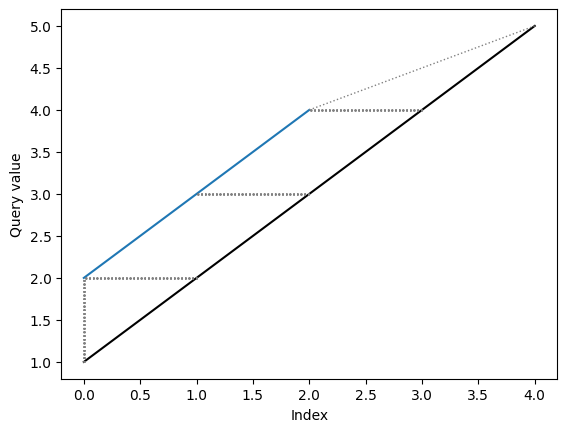

In [11]:
# Example time series data
ts1 = np.array([1, 2, 3, 4, 5])
ts2 = np.array([2, 3, 4])

# Compute normalized DTW distance
distance = normalized_dtw_distance(ts1, ts2)
print(f"Normalized DTW Distance: {distance}")


Normalized DTW Distance: 2.0


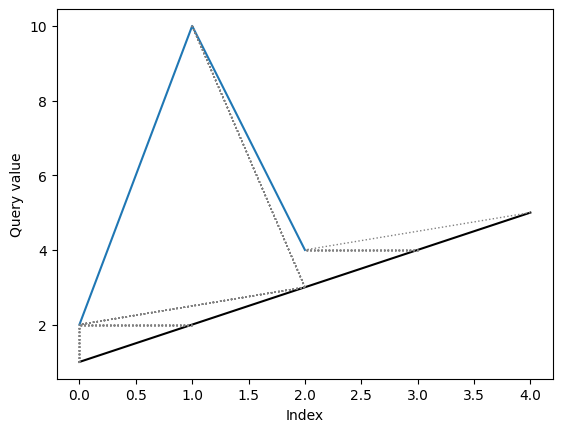

In [12]:
# Example time series data
ts1 = np.array([1, 2, 3, 4, 5])
ts2 = np.array([2, 10, 4])

# Compute normalized DTW distance
distance = normalized_dtw_distance(ts1, ts2)
print(f"Normalized DTW Distance: {distance}")

# Load the data and compute the normalized DTW distance from event with largest peak intensity to other events

In [2]:
path_to_data = 'C:/Users/the_3/Documents/github/keras-functional-api/data/electron_cme_data_split_v8/full'


In [7]:
import pandas as pd
import os
import numpy as np

# Read all files to get event IDs and extract time series
event_data = []
for file_name in os.listdir(path_to_data):
    if file_name.endswith('_ie_trim.csv'):
        event_id = int(file_name.split('_')[2])  # Extract event number
        file_path = os.path.join(path_to_data, file_name)
        df = pd.read_csv(file_path)
        
        # Get proton intensity time series after log transform
        log_proton_series = np.log1p(df['Proton Intensity'])
        
        # Get peak values
        peak_intensity = np.max(df['Proton Intensity'])
        log_peak_intensity = np.log1p(peak_intensity)
        peak_delta = np.max(df['delta_log_Intensity'])
        
        event_data.append({
            'event_id': event_id,
            'time_series': log_proton_series,
            'peak_intensity': peak_intensity,
            'log_peak_intensity': log_peak_intensity,
            'peak_delta': peak_delta
        })

# Use event 12 as anchor
anchor_event = next(event for event in event_data if event['event_id'] == 12)
anchor_series = anchor_event['time_series']

# Calculate distances
distances = []
for event in event_data:
    distance = normalized_dtw_distance(anchor_series, event['time_series'])
    distances.append({
        'event_id': event['event_id'],
        'distance': distance,
        'peak_intensity': event['peak_intensity'],
        'log_peak_intensity': event['log_peak_intensity'], 
        'peak_delta': event['peak_delta']
    })

# Create DataFrame and sort by distance
results_df = pd.DataFrame(distances)
results_df = results_df.sort_values('distance')

# Display the results
print("\nResults table (sorted by distance from Event 12):")
print(results_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))



Results table (sorted by distance from Event 12):
 event_id  distance  peak_intensity  log_peak_intensity  peak_delta
       12    0.0000        353.9040              5.8718      1.7164
       10    0.1807        229.3620              5.4397      1.3985
       31    0.2302         93.0270              4.5436      0.5265
       44    0.2386         78.7868              4.3794      2.3158
       27    0.2488         81.2694              4.4100      1.2491
       38    0.2677        129.7824              4.8735      1.2445
       13    0.3746         41.7726              3.7559      1.7283
       11    0.3801         58.6158              4.0879      1.0971
       35    0.4717         25.2998              3.2696      0.9356
       43    0.4924         63.7880              4.1711      1.0562
       28    0.5651         19.8000              3.0350      1.1481
        5    0.5766         20.4640              3.0664      1.0373
       19    0.8202          9.9734              2.3955      1.04

In [6]:
# Normalize DTW distances between 0 and 1
min_dist = results_df['distance'].min()
max_dist = results_df['distance'].max() 
results_df['normalized_dtw'] = (results_df['distance'] - min_dist) / (max_dist - min_dist)

# Normalize peak deltas between 0 and 1
min_delta = results_df['peak_delta'].min()
max_delta = results_df['peak_delta'].max()
results_df['normalized_delta'] = (results_df['peak_delta'] - min_delta) / (max_delta - min_delta)

# Calculate combined score: (1 - normalized_dtw + normalized_delta)/2
results_df['combined_score'] = (1 - results_df['normalized_dtw'] + results_df['normalized_delta'])/2

# Sort by combined score in descending order
results_df = results_df.sort_values('combined_score', ascending=False)

# Display results with all columns
print("\nResults table (sorted by combined score):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(results_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))



Results table (sorted by combined score):
 event_id  distance  peak_intensity  log_peak_intensity  peak_delta  normalized_dtw  normalized_delta  combined_score
       44    0.2386         78.7868              4.3794      2.3158          0.1007            1.0000          0.9497
       12    0.0000        353.9040              5.8718      1.7164          0.0000            0.7328          0.8664
       13    0.3746         41.7726              3.7559      1.7283          0.1581            0.7381          0.7900
       10    0.1807        229.3620              5.4397      1.3985          0.0762            0.5911          0.7574
       27    0.2488         81.2694              4.4100      1.2491          0.1050            0.5245          0.7098
       38    0.2677        129.7824              4.8735      1.2445          0.1130            0.5225          0.7048
       11    0.3801         58.6158              4.0879      1.0971          0.1604            0.4568          0.6482
       28    

In [8]:
# Define the training and test event IDs
train_events = [44, 12, 20, 27, 38, 11, 43, 5, 35, 2, 41, 16, 22, 32, 34, 1, 6, 36, 26, 29, 24, 4, 14, 15, 42, 37, 3, 40, 18]
test_events = [13, 10, 28, 19, 25, 9, 33, 31, 8, 17, 21, 30, 23, 39, 7]

# Create training and test dataframes
train_df = results_df[results_df['event_id'].isin(train_events)]
test_df = results_df[results_df['event_id'].isin(test_events)]

# Define intensity bins
bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5]
labels = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5']

# Calculate distributions for training set
train_dist = pd.cut(train_df['peak_delta'], bins=bins, labels=labels).value_counts().sort_index()
print("\nTraining set distribution:")
for label, count in train_dist.items():
    print(f"{label}: {count} events")

# Calculate distributions for test set  
test_dist = pd.cut(test_df['peak_delta'], bins=bins, labels=labels).value_counts().sort_index()
print("\nTest set distribution:")
for label, count in test_dist.items():
    print(f"{label}: {count} events")



Training set distribution:
0-0.5: 14 events
0.5-1.0: 7 events
1.0-1.5: 6 events
1.5-2.0: 1 events
2.0-2.5: 1 events

Test set distribution:
0-0.5: 7 events
0.5-1.0: 4 events
1.0-1.5: 3 events
1.5-2.0: 1 events
2.0-2.5: 0 events
